# 3. Identifying objects

In [ ]:
import numpy as np
import os
from io import BytesIO
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import matplotlib.pyplot as plt
from collections import defaultdict
from io import StringIO
from PIL import Image

In [2]:
sys.path.append("../../../Python Samples/_TensorFlow/models/research/")
from object_detection.utils import ops as utils_ops

In [6]:
sys.path.append("../../../Python Samples/_TensorFlow/models/research/object_detection/")
from utils import label_map_util
from utils import visualization_utils as vis_util

In [7]:
%matplotlib inline

In [8]:
graph = '../../../Python Samples/_TensorFlow/models/frozen_inference_graph.pb'
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(graph, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [9]:
labels = '../../../Python Samples/_TensorFlow/models/labelmap.pbtxt'
CLASS_NUM = 1
label_map = label_map_util.load_labelmap(labels)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=CLASS_NUM,
                                                            use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [10]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()) \
        .reshape((im_height, im_width, 3)).astype(np.uint8)

In [11]:
def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in ['num_detections', 'detection_boxes', 'detection_scores', \
                        'detection_classes', 'detection_masks']:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
            if 'detection_masks' in tensor_dict:
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            output_dict = sess.run(tensor_dict,
                                 feed_dict={image_tensor: np.expand_dims(image, 0)})

            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
              'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

In [16]:
def analyze_api_results(image):
    image_np = load_image_into_numpy_array(image)
    image_np_expanded = np.expand_dims(image_np, axis=0)
    output_dict = run_inference_for_single_image(image_np, detection_graph)

In [17]:
IMAGE_SIZE = (12, 8)
def vis_detection (path_photo):
    image = Image.open(path_photo)
    image_np = load_image_into_numpy_array(image)
    image_np_expanded = np.expand_dims(image_np, axis=0)
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,line_thickness=6)
    plt.figure(figsize=IMAGE_SIZE)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image_np)
    plt.savefig(path_photo.replace('/','/identifying_'),bbox_inches='tight')

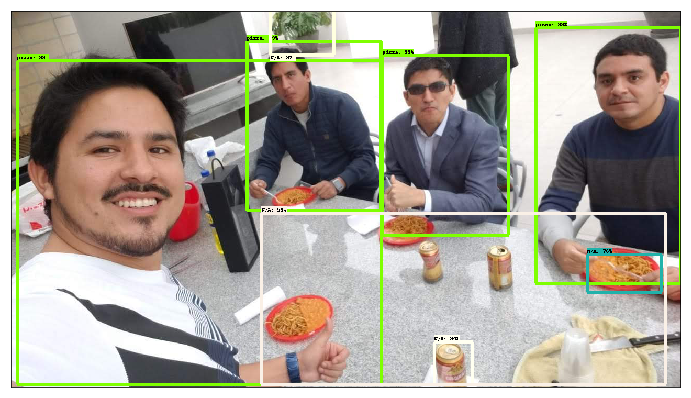

In [18]:
path_photo_a = 'snapshot/teamA.jpg'
vis_detection(path_photo_a)

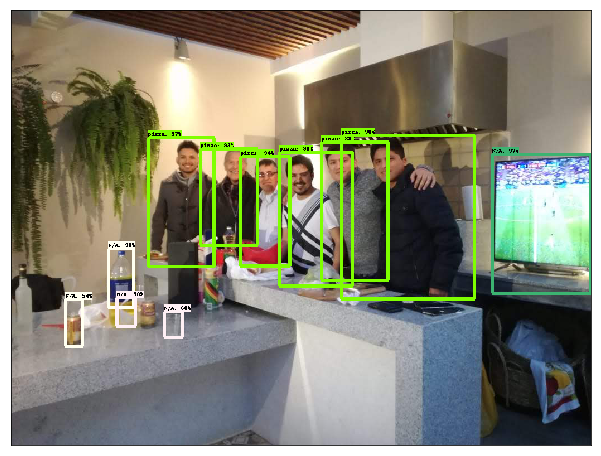

In [19]:
path_photo_b = 'snapshot/teamB.jpg'
vis_detection(path_photo_b)